## Solution Approach

A mathematical optimization model has five components, namely:

* Sets and indices.
* Parameters.
* Decision variables.
* Objective function(s).
* Constraints.

## Model Formulation

### Sets and Indices

$G(N,E)$: Graph that represents the airport network, where $N$ is the set of vertices and $E$ is the set of edges. The sirports are vertices in the set of nodes $N$ of the graph. The set of flight paths are the edges of the graph.(we assume there is a flight path between each pair of airports) 

$K=\{1,2\}$ represents the depots of JFK and LAX and also represents the plane that start from the depots

### Parameters
$d_{i,j} \in \mathbb{R}^+ $:haversine distance from vertex $i \in N$ to vertex $j \in N$.



### Decision Variables
$x_{ijk} = \begin{cases} 
1 & \text{if plane } k \text{ travels from node } i \text{ to node } j, i \neq j; \\
0 & \text{otherwise.}
\end{cases}$


## Miller-Tucker-Zemlin TSP Formulation
# 
### Objective Function
Minimize the total distance traveled:
# 
$$
\min \sum_{i \in N} \sum_{j \in N} \sum_{k \in K} d_{ij} x_{ijk}
$$
# 
### Constraints
1. Each node must be departed from exactly once:
$$
\sum_{k\in K}\sum_{j \in N, j \neq i} x_{ijk} = 1 \quad \forall i \in N-K, \forall K \in K
$$
2. Each node must be arrived at exactly once:
$$
\sum_{k\in K}\sum_{i \in N, i \neq j} x_{ijk} = 1 \quad \forall j \in N-K,\forall K \in K
$$
3. Plane-Specific Flow Conservation Constraints
plane $k$ can only depart from country $i$ if it has arrived there
$$
\sum_{j \in N, j \neq i} x_{jik} - \sum_{j \in N, j \neq i} x_{ijk} = 0 \quad \forall i \in N-k, \forall k \in K
$$


4. Subtour elimination constraints:
$$
u_{ik} + 1 \leq u_{jk} + (n-|K|-1)(1-x_{ijk}), \quad \forall i, j \in N-K, i \neq j \neq 1,\forall k \in K
$$
where $|K|=2$


55. Order constraints:
$$
u_{kk} = 1,\forall k \in K
$$
$$
2 \leq u_{ik} \leq n - |K| + 1 \quad \forall i \in N \setminus K, \forall k \in K
$$
where |K|=2

6. Start and End at Their Respective Depots
Departure from Depot:
$$\sum_{j \in N} x_{kjk} = 1 \quad \forall k \in K$$
Return to Depot:
$$\sum_{i \in N} x_{ikk} = 1 \quad \forall k \in K$$

7. No self-loops:
$$
x_{iik} = 0 \quad \forall i \in N, \forall k \in K
$$
8. Binary constraints on decision variables:
$$
x_{ijk} \in \{0, 1\} \quad \forall i \in N, j \in N, i \neq j,\forall k \in K
$$

In [6]:
from pprint import pprint
import pandas as pd
import networkx as nx
from haversine import haversine, Unit

# Load the data
data = pd.read_csv('airports.csv')
# Add one to the first column value
data['Unnamed: 0'] = data['Unnamed: 0'] + 1

# Create a graph
G = nx.Graph()

# Add nodes
for index, row in data.iterrows():
    G.add_node(row['Unnamed: 0'], country=row['country'], airport_name=row['airport_name'], airport_code=row['airport_code'], latitude_deg=row['latitude_deg'], longitude_deg=row['longitude_deg'])

# Add edges with haversine distance as weight
for i, row1 in data.iterrows():
    for j, row2 in data.iterrows():
        if i != j:
            coord1 = (row1['latitude_deg'], row1['longitude_deg'])
            coord2 = (row2['latitude_deg'], row2['longitude_deg'])
            distance = haversine(coord1, coord2, unit=Unit.KILOMETERS)
            G.add_edge(row1['Unnamed: 0'], row2['Unnamed: 0'], weight=distance)

print(G)
nodes_excluding_depots = set(G.nodes) - {1, 2}

Graph with 45 nodes and 990 edges


In [7]:
from gurobipy import *
import gurobipy as gp
import numpy as np
import random

import matplotlib.pyplot as plt
import networkx as nx
# Define sets
N = list(G.nodes)  # All nodes
K = [1, 2]  # Depots (1 is index of JFK and 2 is LAX)
V = [node for node in N if node not in K]  # Nodes excluding depots coresbonding to N-K in the formula

# Create a new model
mtz = gp.Model("TSP_MTZ")
mtz.Params.MIPGap = 0.10  # Set the target accuracy to 5% of the optimal
# Create Decision variables: x_{ijk}
# also satisfy constraint 7. No self-loops 8.binary constraint

x = mtz.addVars([(i, j, k) for i in N for j in N for k in K if i != j],
                vtype=GRB.BINARY, name="x")

# Subtour elimination variables: u_{ik}
u = mtz.addVars([(i, k) for i in N for k in K],
                vtype=GRB.CONTINUOUS, name="u")

# Objective: minimize the total distance traveled
mtz.setObjective(gp.quicksum(x[i, j, k] * G.edges[i, j]['weight']
                             for i in N for j in N for k in K if i != j), GRB.MINIMIZE)

# Constraints

# 1. Each node (excluding depots) must be departed from exactly once
for i in V:
    mtz.addConstr(gp.quicksum(x[i, j, k] for j in N if i != j for k in K) == 1,
                  name=f"Depart_{i}")

# 2. Each node (excluding depots) must be arrived at exactly once
for j in V:
    mtz.addConstr(gp.quicksum(x[i, j, k] for i in N if i != j for k in K) == 1,
                  name=f"Arrive_{j}")

# 3. Plane-Specific Flow conservation constraints for each plane k
for k in K:
    for i in V:
        mtz.addConstr(
            gp.quicksum(x[j, i, k] for j in N if j != i) -
            gp.quicksum(x[i, j, k] for j in N if j != i) == 0,
            name=f"Flow_{i}_{k}"
        )

# 4.and 5. Subtour elimination constraints (MTZ)
n = len(V) + len(K)
M = n  # Big M value for MTZ constraints

for k in K:
    mtz.addConstr(u[k, k] == 1, name=f"u_{k}_{k}_start")  # Depot node order is 1

    for i in V:
        mtz.addConstr(u[i, k] >= 2, name=f"u_lb_{i}_{k}")  # Lower bound
        mtz.addConstr(u[i, k] <= n, name=f"u_ub_{i}_{k}")  # Upper bound

for k in K:
    for i in V:
        for j in V:
            if i != j:
                mtz.addConstr(
                    u[i, k] - u[j, k] + M * x[i, j, k] <= M - 1,
                    name=f"MTZ_{i}_{j}_{k}"
                )

# 6. Start and End at Their Respective Depots
# Departure from Depot
for k in K:
    mtz.addConstr(gp.quicksum(x[k, j, k] for j in N if j != k) == 1,
                  name=f"DepartDepot_{k}")

# Return to Depot
for k in K:
    mtz.addConstr(gp.quicksum(x[i, k, k] for i in N if i != k) == 1,
                  name=f"ReturnDepot_{k}")

# Solve the model
mtz.optimize()

# Output the solution
if mtz.status == GRB.OPTIMAL:
    edges = [(i, j, k) for i in N for j in N for k in K if i != j and x[i, j, k].X > 0.5]
    print("Optimal tour:", edges)
else:
    print("No optimal solution found")

Set parameter MIPGap to value 0.1
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3962 rows, 4050 columns and 26322 nonzeros
Model fingerprint: 0x6318c479
Variable types: 90 continuous, 3960 integer (3960 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [1e+02, 2e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Found heuristic solution: objective 472081.15855
Presolve removed 174 rows and 4 columns
Presolve time: 0.03s
Presolved: 3788 rows, 4046 columns, 26148 nonzeros
Variable types: 86 continuous, 3960 integer (3960 binary)

Root relaxation: objective 4.622130e+04, 112 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unex

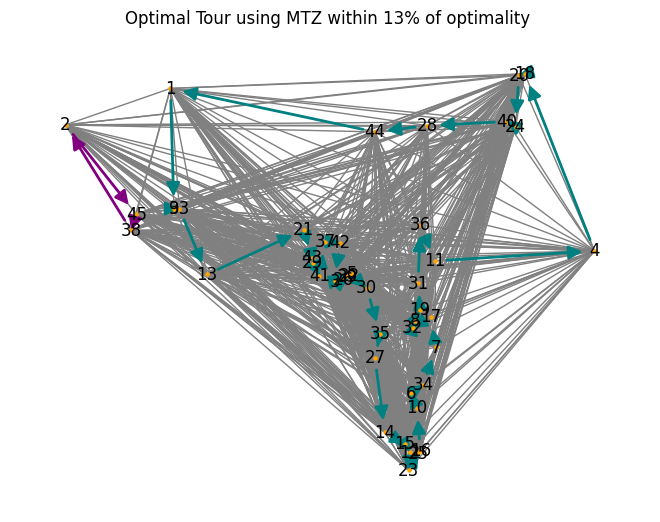

In [9]:
# Define the optimal tour provided by gurobi
optimal_tour_k1 = [(i, j) for i, j, k in edges if k == 1]  # Extract node pairs for k=1
optimal_tour_k2 = [(i, j) for i, j, k in edges if k == 2]  # Extract node pairs for k=2

# Draw the network with the optimal path highlighted
G_optimal_k1 = nx.DiGraph()
G_optimal_k1.add_edges_from(optimal_tour_k1)
G_optimal_k2 = nx.DiGraph()
G_optimal_k2.add_edges_from(optimal_tour_k2)

# Define the positions of the nodes based on latitude and longitude
pos = {node: (G.nodes[node]['longitude_deg'], G.nodes[node]['latitude_deg']) for node in G.nodes}

# Draw the full graph with all nodes
nx.draw(G, pos, with_labels=True, node_color='orange', node_size=5, edge_color='gray', arrows=True)

# # Overlay the optimal tour for k=1 with a different edge color
nx.draw_networkx_edges(G_optimal_k1, pos, edge_color='teal', width=2, arrows=True, arrowstyle='-|>', arrowsize=20)

# Overlay the optimal tour for k=2 with another different edge color
nx.draw_networkx_edges(G_optimal_k2, pos, edge_color='purple', width=2, arrows=True, arrowstyle='-|>', arrowsize=20)

plt.title('Optimal Tour using MTZ within 13% of optimality ')
plt.show()